# Bootstrapping with Yukawa Potential to first order

Similar to Coulomb Potential (Hydrogen Atom), but the Yukawa potential is $V(r)=-\frac{k}{r}e^{-a mr}$.

In [1]:
import os, time
import numpy as np
import sympy as sp
from bootstrap_sympy import sympy_solve_intervals, plot_energy_interval

import matplotlib.pyplot as plt
import seaborn as sns

## Recursion relation for Yukawa Potential to first order

The recursion relation can be easily derived. Consider $l=0$ case:

\begin{equation*}
    \frac{1}{4}(s+1)s(s-1)\langle r^{s-2}\rangle + 2E(s+1)\langle r^s\rangle
    -a k\langle r^s e^{-a r}\rangle + k(2s+1)\langle r^{s-1}e^{-a r}\rangle = 0
\end{equation*}

To the first order, we set $e^{-ar} = 1-ar + O(a^2)$, and discard higher order terms. Add the angular momentum terms, we can get

\begin{equation*}
    \langle r^s\rangle = -\frac{1}{E-a k}\frac{k(2s+1)}{2(s+1)}\langle r^{s-1}\rangle
    -\frac{1}{E-a k} [\frac{s(s-1)}{8} - \frac{sl(l+1)}{2(s+1)}]\langle r^{s-2}\rangle
\end{equation*}

$\langle r^0\rangle=1$ by normalization. Take $s=1$, we get $\langle r^1\rangle=-\frac{3k}{4(E-a k)}-\frac{l(l+1)}{2k}$.

Set $E^\prime = -\frac{1}{E-ak}$, we get $\langle r^1\rangle=\frac{3k}{4}E^\prime-\frac{l(l+1)}{2k}$ and

\begin{equation*}
    \langle r^s\rangle = E^\prime\frac{k(2s+1)}{2(s+1)}\langle r^{s-1}\rangle
    +E^\prime[\frac{s(s-1)}{8} - \frac{sl(l+1)}{2(s+1)}]\langle r^{s-2}\rangle
\end{equation*}

In [2]:
class FirstOrderYukawaPotentialMatrix:
    def __init__(self, N, angular_momentum=True):
        self.N = N # maximum size of submatrix
        self.k = sp.symbols('k') # constant of harmonic potential
        self.E = sp.symbols('E') # eigen-energy to be solved (Note the true energy is 1/E)
        self.l = sp.symbols('l') # angular momentum quantum number
        self.a = sp.symbols('a') # Yukawa potential scaling constant
        self.angular_momentum = angular_momentum
        
    def evaluate(self):
        '''
            - If assign the value of other paramters (i.e., k) first, it will give the matrix element list with only E
            - Otherwise it will represented ohter parameters with symbols
        '''
        self.rs_list = [] # list of r^s, the expectation value of position operator r to the s power
        for i in range(2*(self.N-1)+1):
            if i >= 2:
                self.rs_list.append(self.rs_recursion(s=i, rs_1=self.rs_list[i-1], rs_2=self.rs_list[i-2]))
            else:
                self.rs_list.append(self.rs_recursion(s=i))

    def rs_recursion(self, s, rs_1=None, rs_2=None):
        '''
            Find the <r^s> with recursion relation
        '''
        E = self.E # It is actually E'
        k = self.k
        l = self.l
        a = self.a
        if s == 0:
            return 1
        elif s == 1:
            result = sp.Rational(3,4) * k * E
            if self.angular_momentum:
                result += -sp.Rational(1,2) * l*(l+1) / k
            return result
        else:
            if rs_1 == None or rs_2 == None:
                rs_1 = self.rs_recursion(s-1)
                rs_2 = self.rs_recursion(s-2)
            result  = k * sp.Rational(2*s+1,2*s+2) * rs_1 * E
            result += sp.Rational(s*(s-1),8) * rs_2 * E
            if self.angular_momentum:
                result += -sp.Rational(s,2*s+2) * l*(l+1) * rs_2 * E
            return sp.simplify(result)

    def submatrix(self, K):
        '''
            K by K matrix's [i,j] element = <r^(i+j)>
        '''
        return sp.Matrix([[self.rs_list[i+j] for j in range(K)] for i in range(K)])

## Set hyperparameters

We set hyperparameters in the `config` dictionary. Here is some following instructions of the function `matrix.evaluate()`:
- If you want to see the expression of matrix elements and determinants with other explicit parameters (i.e., $k$), please evaluate the matrix before assigning numerical values, or just simply remove lines `matrix.k = ...`  , .etc.
- On the other hand, to accelerate the computation, please assign the numerical values (except $E$) before `matrix.evaluate()`

**Warning** : According to the author, $l=0$ will be failed.

In [3]:
# saving paths
save_dir = os.path.abspath('yukawa_order1')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

ykw1_config = {
    'round' : 15, # maximum size of submatrix to compute the determinant
    'initial_interval' : sp.Interval(0, sp.oo), # Expect the energy after transformation to be positive
}

ykw1_matrix = FirstOrderYukawaPotentialMatrix(N=ykw1_config['round'], angular_momentum=True)
ykw1_matrix.k = 1
ykw1_matrix.l = 1 # set l>=1, otherwise l=0 will be failed
ykw1_matrix.a = 1

k, l, a = ykw1_matrix.k, ykw1_matrix.l, ykw1_matrix.a
ykw1_config['npy_energy_intervals'] = os.path.join(save_dir, f"energy_intervals_a{sp.N(a):.2f}_k{sp.N(k):.2f}_l{l}.npy")

ykw1_matrix.evaluate()
energy_intervals = sympy_solve_intervals(ykw1_matrix, ykw1_config, mode='Poly')

Checkpoint exists, checkpoint max K=15



## Theoretic energy eigenvalues to first order

We expect for small $a$, the energy eigenvalues should be close to Hydrogen's energy eigenvalues.

For Hydrogen atom, the energy eigenvalues are $E^l_{n_r}=-\frac{\hbar^2}{2m_ea_0^2(n_r+l+1)^2}$, with the Bohr radius $a_0=\frac{4\pi\epsilon_0\hbar^2}{m_ee^2}=\frac{\hbar^2}{m_ek}$. We now set $m_e=\hbar=1$, the Bohr radius becomes $a_0=\frac{1}{k}$, and $E^l_{n_r}(k)=-\frac{k^2}{2(n_r+l+1)^2}$. Note that $n_r$ starts from $0$.

**Warning** : Since we have transform $E^\prime=-\frac{1}{E}$, the energy intervals we solved will be $E^\prime=\frac{2(n_r+l+1)^2}{k^2}$.

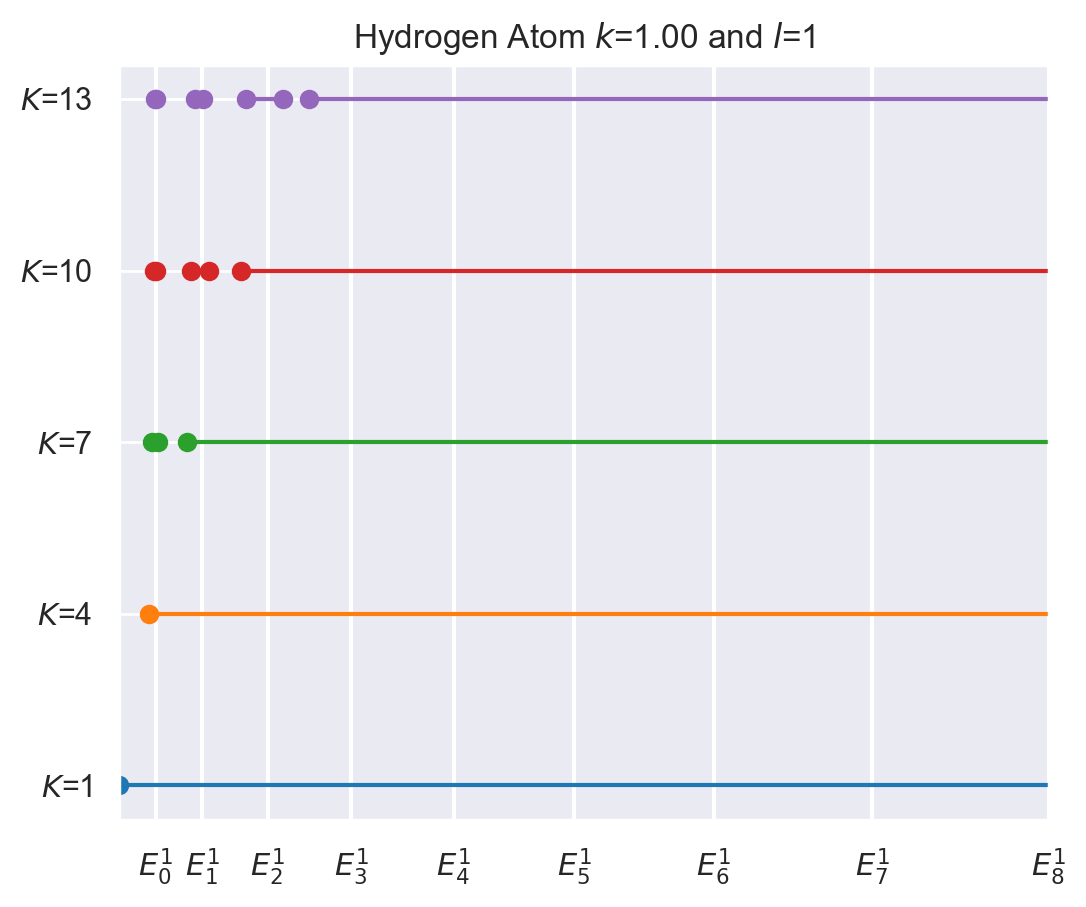

In [4]:
ykw1_config['plot_step'] = 3 # how often to plot the result
ykw1_config['x_inf'] = 0 # infimum for x-axis when plotting
ykw1_config['x_sup'] = 200 # supremum for x-axis when plotting

# n here stands for radial quantum number
energy_eigenvalues = [2*((n+l+1)**2)/k**2 for n in range(ykw1_config['round'])]
x_ticks = [r"$E^{{{}}}_{{{}}}$".format(l,i) for i in range(len(energy_eigenvalues))]

np.save(ykw1_config['npy_energy_intervals'], energy_intervals, allow_pickle=True)

sns.set_style('dark')
sns.set(font_scale=1)
fig, ax = plot_energy_interval(energy_intervals, energy_eigenvalues, x_ticks, ykw1_config, figsize=(6,5), dpi=200)
ax.set_title(f"Hydrogen Atom $k$={sp.N(k):.2f} and $l$={l}")
# ax.set_xlabel(r"$E^l_n = \frac{2(n+l)^2}{k^2}$ with " + r"$l={{{}}}$ and $n>l$".format(l))
plt.savefig(os.path.join(save_dir, f"result_N{ykw1_config['round']}_k{sp.N(k):.2f}_l{l}.png"))